In [67]:
# -*- coding: utf-8 -*- 
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the mems dataset. 
# implemented Advanced Ensemble techniques: Blending


import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
import numpy as np


from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import xgboost as xgb



In [68]:
# Load mems dataset
df = pd.read_csv('/home/ibibers@ads.iu.edu/IOT_Datasets/mems_dataset.csv')

# Drop duplicates
df = df.drop_duplicates(keep='first')

# Drop columns that have just one unique value
one_value = df.columns[df.nunique() == 1]
df = df.drop(columns = one_value, axis=1)

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 21563 entries, 0 to 21575
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       21563 non-null  float64
 1   y       21563 non-null  float64
 2   z       21563 non-null  float64
 3   label   21563 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 842.3 KB


In [69]:
# X-axis: Represents acceleration along the horizontal axis.
# Y-axis: Represents acceleration along the vertical axis.
# Z-axis: Represents acceleration along the depth axis.

# labels 
#1. Normal: This label represents the state of the machine when it is operating under normal conditions, without any significant mechanical imbalance or impending failure.
#2. Near-failure: This label indicates that the machine is experiencing conditions that suggest it is close to a failure state. These conditions may include early signs of mechanical imbalance or other issues that could lead to failure if not addressed.
#3. Failure: This label is assigned when the machine has reached a state of failure, where it is no longer functioning as intended due to mechanical issues or other problems.

# Extract subsample of data
print (" Extract subsample of data: ")
print(df['label'].value_counts())

 Extract subsample of data: 
label
1    10955
2     5771
3     4837
Name: count, dtype: int64


In [70]:
dropped_df = ['label']
X = df.drop(dropped_df, axis=1)
y = df['label']


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

start_time = time.time()

# the base models

model1 = LGBMClassifier()
model2 = CatBoostClassifier()
model3 = SVC(kernel='rbf', probability=True)  
model4 = RandomForestClassifier(n_estimators=200, random_state=42)
model5 = LogisticRegression(solver='lbfgs', multi_class='multinomial')  

start_train_time = time.time()
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)
model4.fit(X_train, y_train)
model5.fit(X_train, y_train)
train_time = time.time() - start_train_time


start_pred_time = time.time()  
pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
pred3 = model3.predict(X_test)
pred4 = model4.predict(X_test)
pred5 = model5.predict(X_test)
pred_time = time.time() - start_pred_time

    # here is the blending part starts, create a new dataset with the predictions of base models
blend_X_train = np.column_stack((pred1, pred2, pred3, pred4 , pred5))

# meta_model = LogisticRegression(random_state=42)
# meta_model = SVC() # 0.Accuracy: 0.7120111300046374
# meta_model = CatBoostClassifier() # Accuracy: 0.7101561292317206
meta_model = LGBMClassifier() 


# Train the meta-model on the blended predictions
meta_model.fit(blend_X_train, y_test)

    # Now, predictions on the test set using the base models
base_model1_pred = model1.predict(X_test)
base_model2_pred = model2.predict(X_test)
base_model3_pred = model3.predict(X_test)
base_model4_pred = model4.predict(X_test)
base_model5_pred = model5.predict(X_test)


    # Create a new dataset with the predictions of base models for the meta-model
blend_X_test = np.column_stack(
        (base_model1_pred, base_model2_pred, base_model3_pred, base_model4_pred , base_model5_pred))

# predictions on the test set using the meta-model
y_pred = meta_model.predict(blend_X_test)


total_time = time.time() - start_time

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 15094, number of used features: 3
[LightGBM] [Info] Start training from score -0.676720
[LightGBM] [Info] Start training from score -1.309427
[LightGBM] [Info] Start training from score -1.506233
Learning rate set to 0.090875
0:	learn: 1.0411252	total: 5.81ms	remaining: 5.8s
1:	learn: 0.9929097	total: 11.2ms	remaining: 5.58s
2:	learn: 0.9534011	total: 16.2ms	remaining: 5.38s
3:	learn: 0.9199618	total: 20.9ms	remaining: 5.21s
4:	learn: 0.8897308	total: 25.6ms	remaining: 5.09s
5:	learn: 0.8637027	total: 30.9ms	remaining: 5.12s
6:	learn: 0.8424582	total: 35.5ms	remaining: 5.03s
7:	learn: 0.8229092	total: 40.3ms	remaining: 5s
8:	learn: 0.8057702	total: 44.7ms	remaining: 4.92s
9:

In [72]:
print("Time taken for training:{:f} seconds".format(train_time))
print("Time taken for prediction: {:f} seconds".format(pred_time))
print("Total time taken:{:f} seconds".format(total_time))

Time taken for training:32.760542 seconds
Time taken for prediction: 2.494066 seconds
Total time taken:37.901988 seconds


In [73]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7206678002782502


In [74]:


# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           1       0.70      0.84      0.76      3283
           2       0.80      0.80      0.80      1696
           3       0.67      0.36      0.47      1490

    accuracy                           0.72      6469
   macro avg       0.72      0.67      0.68      6469
weighted avg       0.72      0.72      0.71      6469



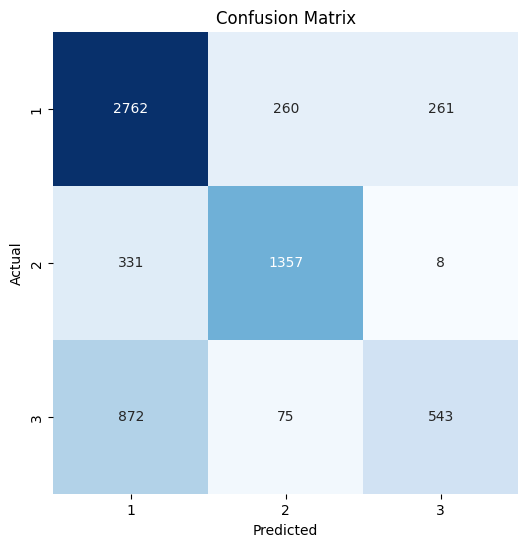

In [75]:

# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test, y_pred)

# Get unique class labels from y_test and y_pred_encoded
unique_labels = np.unique(np.concatenate(
    (y_test, y_pred)))

# Plotting the Confusion Matrix with class labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/tmp/ipykernel_69053/359193914.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importance.values,


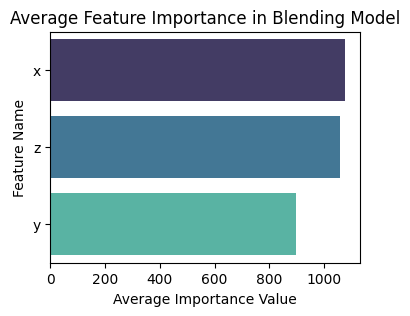

In [76]:

# Extract feature importances from base models
base_models_importances = {}

for i, model in enumerate([model1, model2, model3, model4]):
    if hasattr(model, 'feature_importances_'):
        base_models_importances[f'base_model_{i}'] = model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame(base_models_importances, index=X.columns)

# Calculate average feature importance across base models
average_importance = importance_df.mean(axis=1)

# Sort features by average importance
sorted_importance = average_importance.sort_values(ascending=False)

# Visualize the feature importances
plt.figure(figsize=(4, 3))
sns.barplot(x=sorted_importance.values,
            y=sorted_importance.index, palette='mako')
plt.xlabel('Average Importance Value')
plt.ylabel('Feature Name')
plt.title('Average Feature Importance in Blending Model')
plt.show()